In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

sns.set_theme()

In [2]:
import os

PLOT_DIR = "example-plots"

if not(os.path.exists(PLOT_DIR)):
    os.mkdir(PLOT_DIR)

In [3]:
# Load data
results_files = ["results-compilespace.csv"]

df_raw = pd.concat(map(lambda f: pd.read_csv(f"results/{f}"), results_files), ignore_index=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Benchmark                 294 non-null    object
 1   Param: problemSize        294 non-null    int64 
 2   Param: optimisationLevel  294 non-null    int64 
 3   Score                     294 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ KB


In [4]:
for col in ["Score", "Score Error (99.9%)"]:
    if col in df_raw and df_raw[col].dtype == object:
        df_raw[col] = df_raw[col].map(lambda s: s.replace(',', '.'), na_action="ignore").astype(float)

# df_raw

In [5]:
df_raw["Param: optimisationLevel"] = df_raw["Param: optimisationLevel"].astype("string")

In [6]:
df = df_raw[df_raw.Benchmark.str.endswith("jfr") == False].copy()
df

,Benchmark,Param: problemSize,Param: optimisationLevel,Score
0,benchmark.stratego2.compilation.stratego.Bench...,10,2,212496
1,benchmark.stratego2.compilation.stratego.Bench...,10,2,248257
2,benchmark.stratego2.compilation.stratego.Bench...,11,2,212499
3,benchmark.stratego2.compilation.stratego.Bench...,11,2,248260
4,benchmark.stratego2.compilation.stratego.Bench...,12,2,212499
...,...,...,...,...
289,benchmark.stratego2.compilation.stratego.Sieve...,1000,4,128611
290,benchmark.stratego2.compilation.stratego.Sieve...,2000,4,124168
291,benchmark.stratego2.compilation.stratego.Sieve...,2000,4,128760
292,benchmark.stratego2.compilation.stratego.Sieve...,10000,4,124159


In [7]:
df["Stage"] = df["Benchmark"].str.rpartition('.')[2]
df["Problem"] = df["Benchmark"].str.split('.').map(lambda l: l[-2])

In [8]:
df

,Benchmark,Param: problemSize,Param: optimisationLevel,Score,Stage,Problem
0,benchmark.stratego2.compilation.stratego.Bench...,10,2,212496,Class space,Benchexpr
1,benchmark.stratego2.compilation.stratego.Bench...,10,2,248257,Java space,Benchexpr
2,benchmark.stratego2.compilation.stratego.Bench...,11,2,212499,Class space,Benchexpr
3,benchmark.stratego2.compilation.stratego.Bench...,11,2,248260,Java space,Benchexpr
4,benchmark.stratego2.compilation.stratego.Bench...,12,2,212499,Class space,Benchexpr
...,...,...,...,...,...,...
289,benchmark.stratego2.compilation.stratego.Sieve...,1000,4,128611,Java space,Sieve
290,benchmark.stratego2.compilation.stratego.Sieve...,2000,4,124168,Class space,Sieve
291,benchmark.stratego2.compilation.stratego.Sieve...,2000,4,128760,Java space,Sieve
292,benchmark.stratego2.compilation.stratego.Sieve...,10000,4,124159,Class space,Sieve


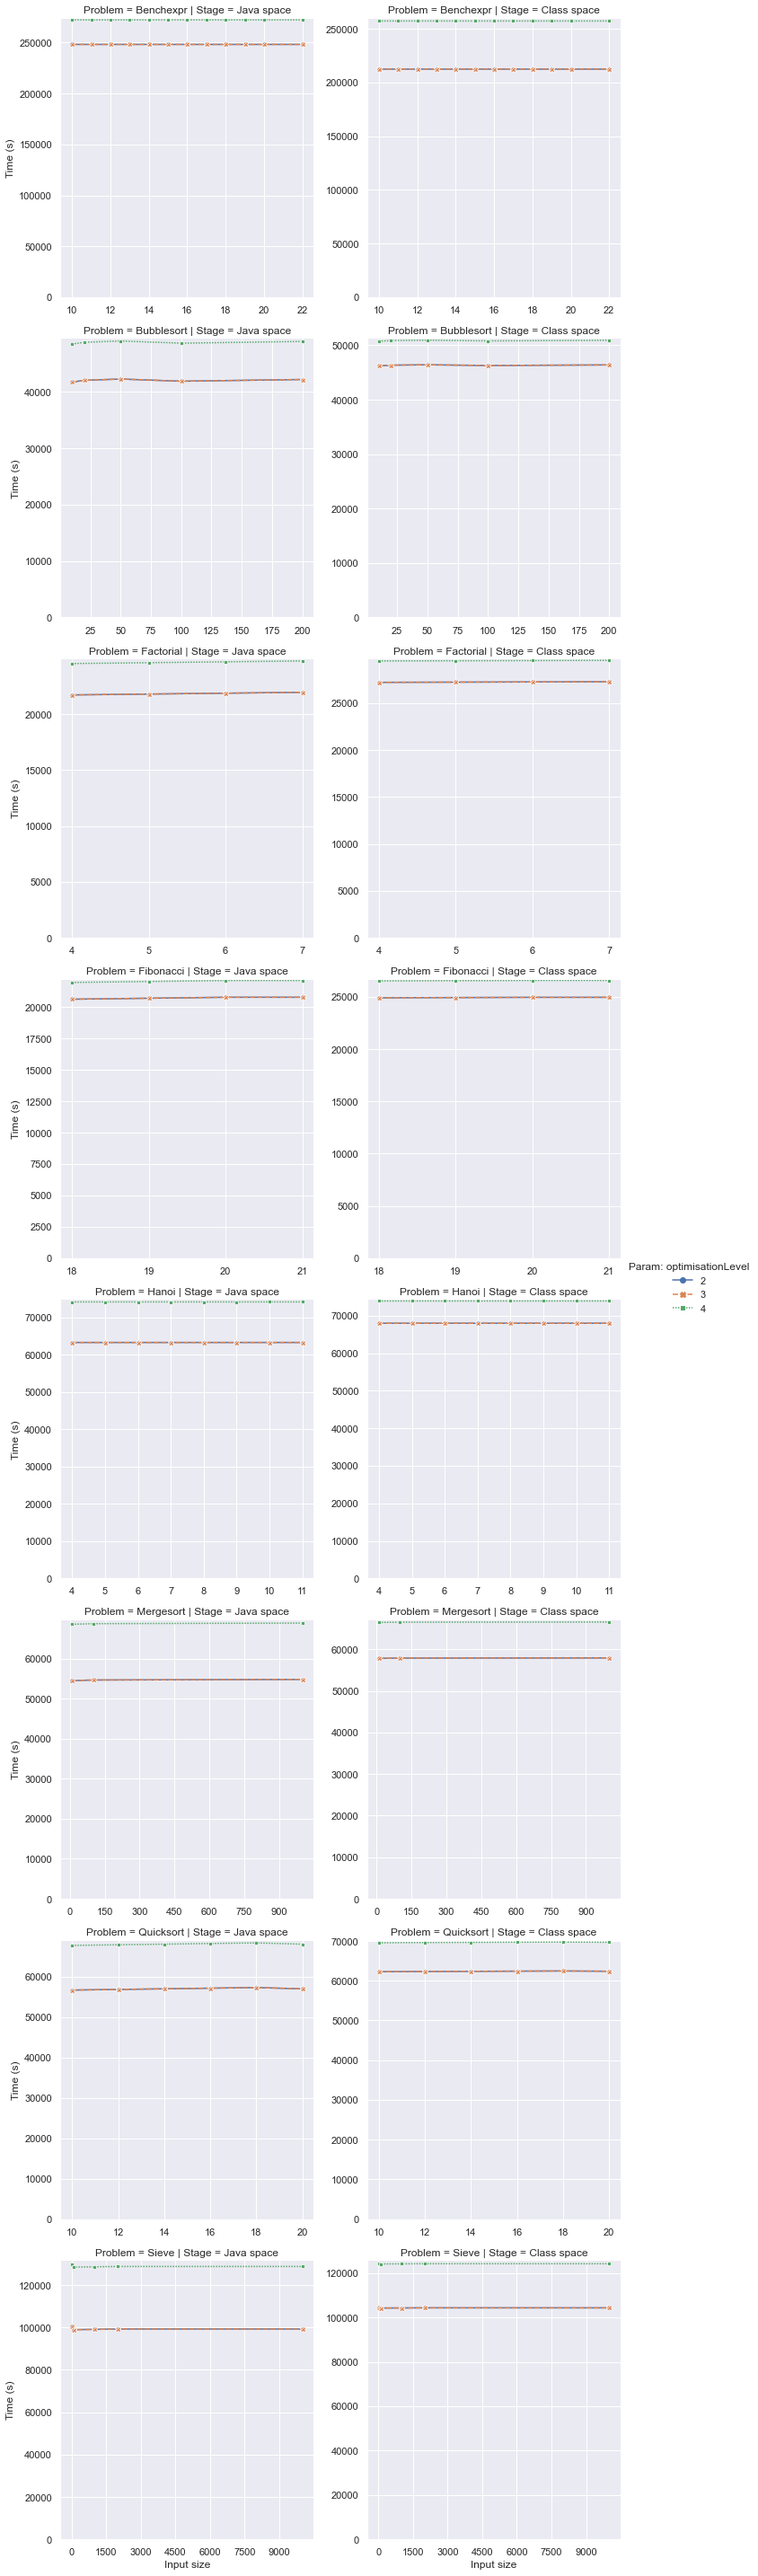

In [9]:
df_scaledproblem = df[df["Param: problemSize"] != -1]

g = sns.relplot(
    data=df_scaledproblem,
    x="Param: problemSize",
    y="Score",
    row="Problem",
    row_order=np.sort(np.unique(df_scaledproblem["Problem"].values)),
    col="Stage",
    col_order=[s for s in ["compileStratego", "Java space", "compileJava", "Class space", "run"] if s in df_scaledproblem["Stage"].values],
    style="Param: optimisationLevel",
    hue="Param: optimisationLevel",
    hue_order=["2", "3", "4"],
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
)

# TODO Include strj runtime -> with and without fusion


## Global settings
g.set_ylabels("Time (s)")
g.set_xlabels("Input size")
for axs in g.axes:
    for ax in axs:
        ax.get_xaxis().set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

## Plot-specific settings
configs = [
    {
        "problems": {"Benchexpr", "Bubblesort", "Factorial", "Hanoi", "Quicksort"},
        "stages": {"run"},
        "settings": {"yscale": "log"}
    },
    {
        # Apply to all problems
        "stages": {"compileStratego", "compileJava", "Java space", "Class space"},
        "settings": {"ylim": (0, None)}
    }
]

for (row_val, col_val), ax in g.axes_dict.items():
    for config in configs:
        if "problems" not in config or row_val in config["problems"]:
            if "stages" not in config or col_val in config["stages"]:
                ax.set(**config["settings"])


# Save figure to file
plt.savefig(f"example-plots/{'_'.join(results_files)}-scaled.png", transparent=False)

In [10]:
df_unscaledproblem = df[df["Param: problemSize"] == -1]

print(df_unscaledproblem.to_latex(
    columns=["Problem", "Stage", "Samples", "Score", "Score Error (99.9%)", "Param: optimisationLevel"]
))

df_unscaledproblem

/var/folders/yh/005cg_5s02b63kq3xy2lfyfh0000gn/T/ipykernel_69282/4144059077.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_unscaledproblem.to_latex(


KeyError: "['Samples', 'Score Error (99.9%)'] not in index"